# Task 3: Approximating nonlinear vector fields

In [1]:
from helpers.data import load_dataset
from helpers.plot import plot_phase_portrait
from helpers.models import RBFRegression, get_best_model
import helpers.vectorfields as vf
from scipy.stats import randint
from sklearn.utils.fixes import loguniform
import pandas as pd
import numpy as np

In [2]:
#load data
x_0 = load_dataset("data/nonlinear_vectorfield_data_x0.txt")
x_1 = load_dataset("data/nonlinear_vectorfield_data_x1.txt")

In [3]:
print(x_0.shape)
print(x_1.shape)

(2000, 2)
(2000, 2)


In [4]:
print(x_0)
print(x_1)

             x         y
0    -0.746802  1.982920
1    -4.498971 -1.779007
2    -3.179197 -3.668953
3    -2.823658 -1.389953
4    -0.929093  0.349351
...        ...       ...
1995 -3.650647  3.594317
1996 -3.890063  1.626321
1997  4.247983  1.884364
1998 -1.566822 -3.839039
1999  0.717633  2.101653

[2000 rows x 2 columns]
             x         y
0    -0.793170  2.098244
1    -4.200666 -1.955218
2    -3.323446 -3.549717
3    -2.905656 -1.480816
4    -0.982742  0.428147
...        ...       ...
1995 -3.475128  3.497376
1996 -3.664949  1.735261
1997  3.937381  1.836732
1998 -1.791530 -3.591236
1999  0.788361  2.178699

[2000 rows x 2 columns]


<AxesSubplot:xlabel='x', ylabel='y'>

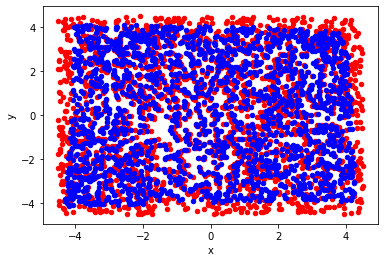

In [5]:
# visualize input data
ax = x_0.plot(kind = 'scatter', x = 'x', y = 'y', color='r')

x_1.plot(kind = 'scatter', x = 'x', y = 'y', color='b', ax=ax)

### Part 1: Estimate the vector field with a linear operator

In [6]:
delta_t = 0.1 # delta_t is unknown at this point so just set it to 0.1
v_k = vf.compute_finite_difference(x_0, x_1, delta_t)
A_T = vf.compute_closed_form_linear(x_0, v_k)


In [7]:
print(A_T.T)

          x         y
x -0.100160 -0.002535
y  0.008673 -0.432671


In [8]:
max_t = 1
num_t = 100
time = np.linspace(0, max_t, num_t)

X_i_head = vf.solve_ode_linear(time, A_T.to_numpy(), x_0)

In [9]:
# find best approximation, error and delta_t
best_error = np.inf
best_x_i = X_i_head[0].reshape(x_0.shape[0], x_0.shape[1])
best_t = 0

for i, x_i in enumerate(X_i_head):
    x_i = x_i.reshape(x_0.shape[0], x_0.shape[1])
    mse = vf.mean_squared_error(x_i, x_1.to_numpy())
    if mse < best_error:
        best_t = i / num_t * max_t
        best_x_i = x_i
        best_error = mse

print("Mean Squared Error is: " + str(best_error))
print("Best delta_t is: " + str(best_t))

Mean Squared Error is: 0.018635903091531413
Best delta_t is: 0.1


### Part 2: Estimate the vector field with radial basis functions

In [10]:
param_grid_rbf_regression = {
    "lamb": loguniform(1e-6, 1e-4),
    "eps": loguniform(1e0, 1e2),
    "L": randint(600, x_0.shape[0]),
}
rbf = RBFRegression()
best_model = get_best_model(param_grid_rbf_regression, rbf, x_0.to_numpy(), v_k.to_numpy(), n_iter=10)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best R2 score:
0.2676685979438618
Best params:
{'L': 1040, 'eps': 6.4978756545239715, 'lamb': 5.5457003929206706e-05}


In [11]:
max_t = 1
num_t = 1000
time = np.linspace(0, max_t, num_t)

X_i_head = vf.solve_ode_nonlinear(time, best_model, x_0)

In [12]:
# find best approximation, error and delta_t
best_error = np.inf
best_x_i = X_i_head[0].reshape(x_0.shape[0], x_0.shape[1])
best_t = 0

for i, x_i in enumerate(X_i_head):
    x_i = x_i.reshape(x_0.shape[0], x_0.shape[1])
    mse = vf.mean_squared_error(x_i, x_1.to_numpy())
    if mse < best_error:
        best_t = i / num_t * max_t
        best_x_i = x_i
        best_error = mse

print("Mean Squared Error is: " + str(best_error))
print("Best delta_t is: " + str(best_t))

Mean Squared Error is: 0.01799601817672025
Best delta_t is: 0.108


In [13]:
print(X_i_head[1].reshape(x_0.shape[0], x_0.shape[1]))
print(x_1)

[[-0.74631954  1.98335216]
 [-4.4997176  -1.77865211]
 [-3.17980266 -3.66831121]
 ...
 [ 4.24696089  1.88254096]
 [-1.56759112 -3.83876504]
 [ 0.71787283  2.10153754]]
             x         y
0    -0.793170  2.098244
1    -4.200666 -1.955218
2    -3.323446 -3.549717
3    -2.905656 -1.480816
4    -0.982742  0.428147
...        ...       ...
1995 -3.475128  3.497376
1996 -3.664949  1.735261
1997  3.937381  1.836732
1998 -1.791530 -3.591236
1999  0.788361  2.178699

[2000 rows x 2 columns]


### Part 3: Analysis of the dynamical system

In [14]:
max_t = 2000
num_t = 2000
time = np.linspace(0, max_t, num_t)

X_i_head = vf.solve_ode_nonlinear(time, best_model, x_0)

              x         y
0     12.715692 -9.673883
1    -15.731823  8.915826
2    -15.730608  8.914611
3     12.707880 -9.666072
4     12.716825 -9.675016
...         ...       ...
1995  12.705641 -9.663832
1996  12.707617 -9.665809
1997  12.724518 -9.682710
1998 -15.729844  8.913847
1999  12.718314 -9.676506

[2000 rows x 2 columns]


<AxesSubplot:xlabel='x', ylabel='y'>

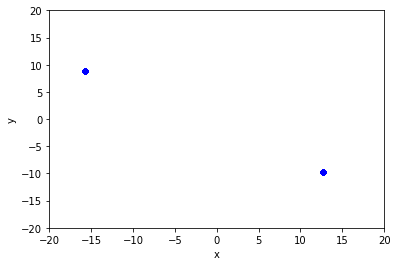

In [15]:
x_final = X_i_head[-1].reshape(x_0.shape[0], x_0.shape[1])
df = pd.DataFrame(data=x_final, columns=x_1.columns)
print(df)

df.plot(kind = 'scatter', x = 'x', y = 'y', color='b', xlim=(-20,20), ylim=(-20,20))



<AxesSubplot:xlabel='x'>

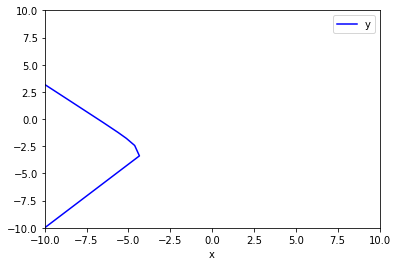

In [16]:
initial = pd.DataFrame(data=[(-10,-10)])

x_1_head = vf.solve_ode_nonlinear(time, best_model , initial)

df = pd.DataFrame(data=x_1_head, columns=x_1.columns)
df.plot(kind = 'line', x = 'x', y = 'y', color='b', xlim=(-10,10), ylim=(-10,10))
